<font color=darkred>

# Soc220: Computational Text Analysis
## Lab 7 (Week 9): Clustering and "vanilla" topic models (or, the inductive reasoning lab!)

<br>


<img src="images/dubois_3.png" style="width: 800px;"/>

<img src="images/dubois_2.png" style="width: 800px;"/>

***

Today:

- LASSO and variable subselection just as an illustration for ML?
- Cross-validation and ML review.
- k-means clustering
- hierarchical clustering
- vanilla topic models
- visualization of topic models

***
    
   

<font color=darkgreen>

#### LASSO Example

https://github.com/zwehrwein/hn_round1_lasso/blob/master/hn_ds_analysis.ipynb

### Load data

- These data are transcripts of the proceedings in The House of Commons from 1660 to 1730.
- We organized these data in two ways: one by date of session and another by monarch (where each doc are all of the proceedings that occured under that King and/or Queen)

In [1]:
!ls

df_proceedings_monarch_and_date.p lab7.ipynb
images


In [2]:
# turn off warnings for some depreciated
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import pickled data (data frames)
import pickle

df_texts = pickle.load(open("df_proceedings_monarch_and_date.p","rb"))

In [4]:
import pandas as pd

df_texts.head()

date   monarch                                               text
0  1660_11  charles2  On the sixth of November the Parliament met ac...
1   1660_4  charles2  CHARLES R.", "Trusty, and Wellbeloved, We gree...
2  1661_11  charles2  After a Recess of almost four Months the Parli...
3   1661_5  charles2  On the 8th of May the new Parliament met, and ...
4   1663_2  charles2  On February 18, 16623. the Parliament met afte...

In [5]:
df_texts.tail()

date  monarch                                               text
106  1738_2  george2  'Feb. 3. Sir Charles Turner being in the Chair...
107  1738_3  george2   'Wednes. March 3. Mr. Alderman Perry presente...
108  1738_4  george2  , ' April 7th. Mr. Speaker reported that the H...
109  1738_5  george2  , " Friday May 12. About 12 o'Clock Mr. Pulten...
110  1739_2  george2  , "Thursday, Feb. 1. A Message came by Sir Cha...

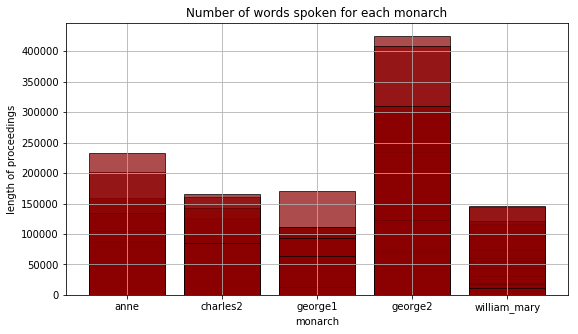

In [6]:
# visualize distribution of words

import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.bar(df_texts['monarch'], df_texts['text'].apply(len).values, color = "darkred", alpha = 0.7, edgecolor="white")
plt.title('Number of words spoken for each monarch')
#plt.xticks(df_texts['monarch'], df_texts['text'].values, rotation=45)
plt.xlabel('monarch')
plt.ylabel('length of proceedings')
plt.grid()

plt.show()

In [7]:
# TSNE to get some sense of the data as well
# Using a TfidfVect that is requiring a minimal frequency plus removing stop words
# Using the Grimmer and Stewart standard 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf  = TfidfVectorizer(min_df=0.2,stop_words='english')
texts  = tfidf.fit_transform(df_texts.text)

#infuriating error code: "Pd.series not unqiue"; hack fix: exit pandas to a list.
labels = df_texts['monarch'].tolist()

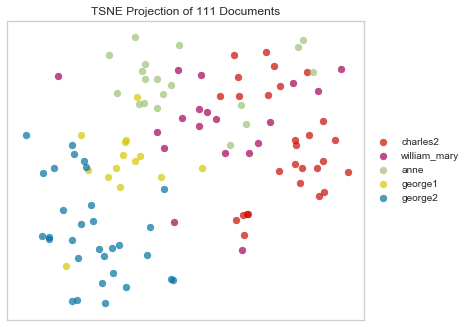

In [8]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(texts,labels)
tsne.poof()

<font color=darkgreen>

## k-means clustering

- Finds k clusters iteratively using random intializations.
- Useful for finding latent groups from data
- Filiz's new book uses this well.

Give a set of observations, k-means aims to partion the n observations $k \leq n$ into sets $s$ where each set minimizes the winthin-cluster sum of squares / variance:

$$\underset{s}{\operatorname{argmin}} \sum^k_{i=1}\sum_{x_n \in S_i} \parallel x_n - \mu_i \parallel^2$$



***


<img src="images/kmeans_wiki.gif" style="width: 400px;"/>


In [9]:
#same as before. import function from sklearn, create an instance of it, and then fit it
#NEXT CLASS: HOW TO SELECT K

from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=6)
clusters.fit(texts)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
#from yellowbrick document:
tsne = TSNEVisualizer()
tsne.fit(texts, ["c{}".format(c) for c in clusters.labels_])

TSNEVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1106e2198>,
        classes=None, colormap=None, colors=None, decompose=None,
        decompose_by=None)

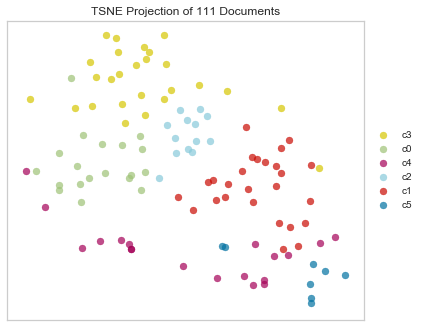

In [11]:
tsne.poof()

In [12]:
kmeans_df = pd.DataFrame({
    'kmeans cluster': clusters.labels_,
    'date':df_texts.date
})

kmeans_df.tail()

date  kmeans cluster
106  1738_2               4
107  1738_3               4
108  1738_4               4
109  1738_5               4
110  1739_2               4

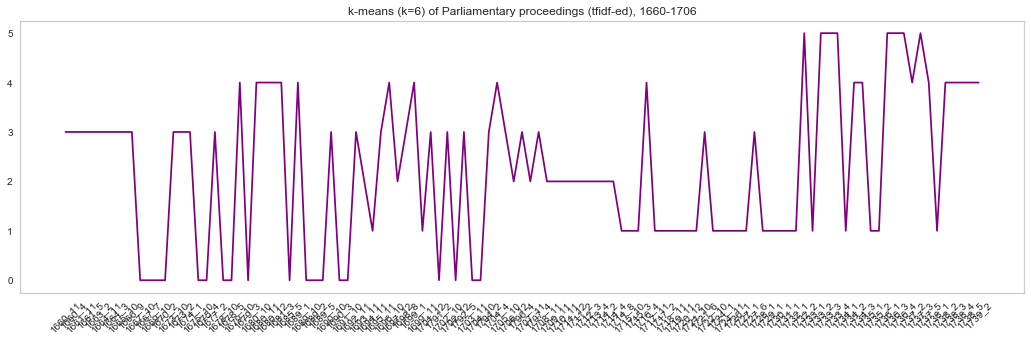

In [29]:
#plot k-means cluster over time
plt.figure(figsize=(18, 5))
plt.plot(kmeans_df.date,kmeans_df['kmeans cluster'],color='purple')
plt.xticks(df_texts.date[::], rotation=45)
plt.title('k-means (k=6) of Parliamentary proceedings (tfidf-ed), 1660-1706')
plt.grid()
plt.show()

<font color=darkgreen>

## Hierarchical clustering


1.) Use a distance metric to calculate how close certain vectors are (here, cosine similarity).

<img src="images/cosine.png" style="width: 400px;"/>

2.) Then, several ways to do linkages:

- Single linkage: the distance between two clusters is defined as the shortest distance between two points in each cluster.
- Complete linkage: the distance between two clusters is defined as the longest distance between two points in each cluster.
- Average linkage: you guessed it, the average distance between each point in one clsuter to every point in teh other cluster.

3.) The iterative steps are as follows: compute the distance between each of the clusters (using the specified linkage method) and continue to join the two most similar clusters together and continute to do so until there is one cluster left.

***

<img src="images/hierarch.gif" style="width: 600px;"/>

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram

cosine_sim_texts = cosine_similarity(texts)

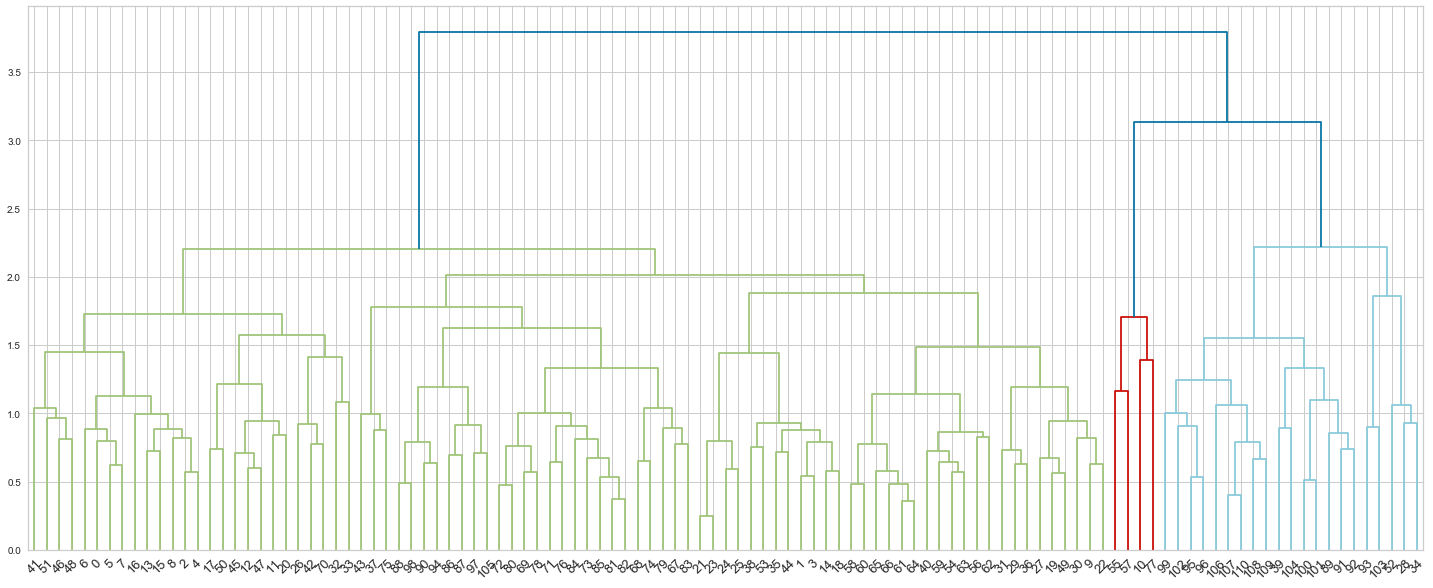

In [15]:
#'complete' clustering, aka the Farthest Point Algorithm
mergings = linkage(cosine_sim_texts, method='complete')

#this is creating an extra large figure size
fig = plt.figure(figsize=(25,10))

dendrogram(mergings,
           leaf_rotation=45,
           leaf_font_size=13,
)
plt.show()

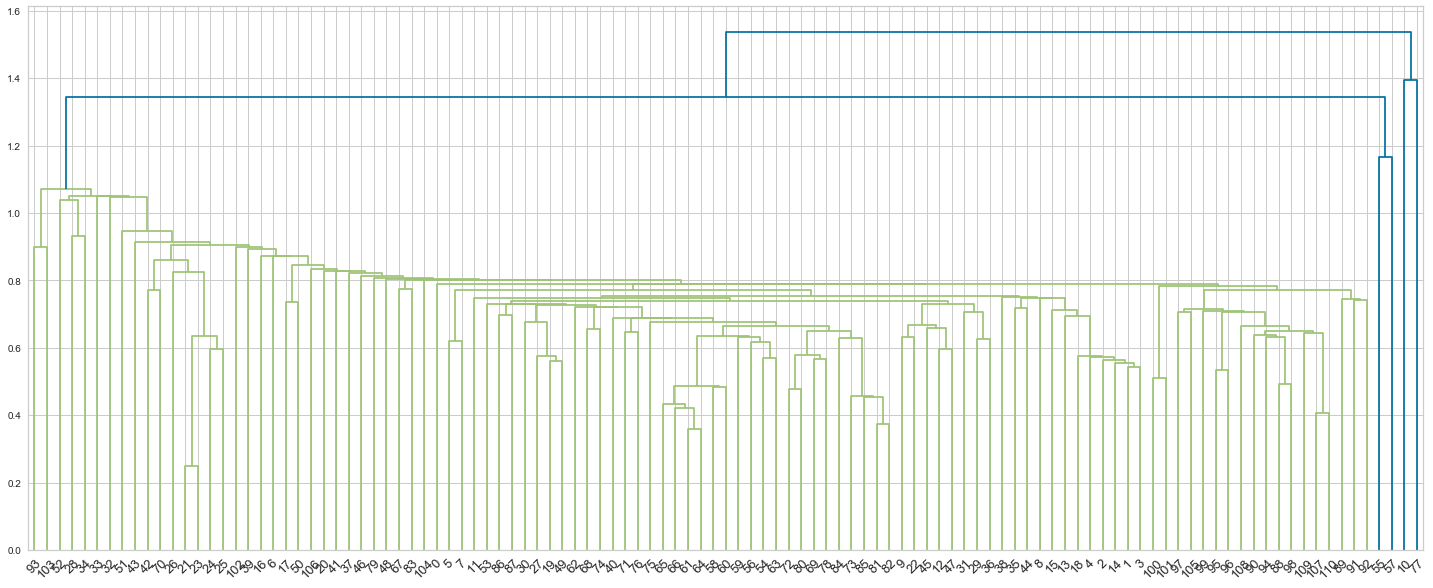

In [16]:
#'single' clustering, aka the Nearest Point Algorithm
mergings = linkage(cosine_sim_texts, method='single')

#this is creating an extra large figure size
fig = plt.figure(figsize=(25,10))

dendrogram(mergings,
           leaf_rotation=45,
           leaf_font_size=13,
)
plt.show()

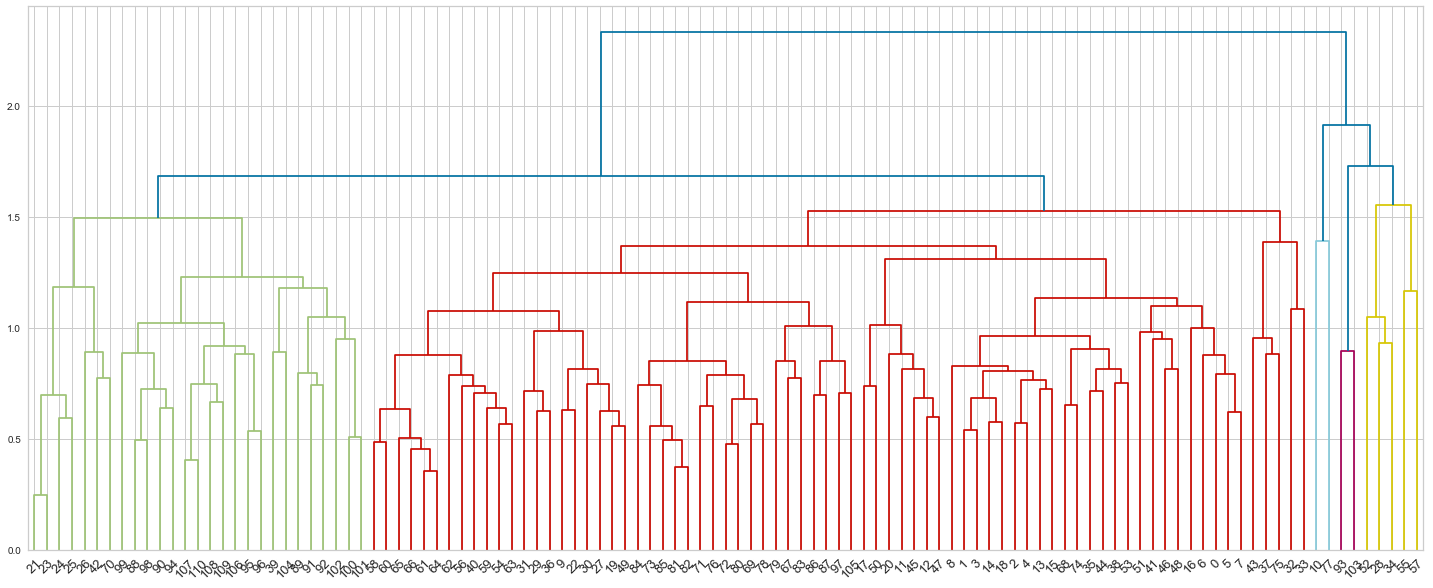

In [17]:

mergings = linkage(cosine_sim_texts, method='average')

#this is creating an extra large figure size
fig = plt.figure(figsize=(25,10))

dendrogram(mergings,
           leaf_rotation=45,
           leaf_font_size=13,
           
)
plt.show()

***
***
<font color=darkgreen>

# 'Vanilla' Topic Model: Latent Dirichlet allocation


<img src="images/Illustrating_LDA.jpg" style="width: 700px;"/>


- We care about three things:
1) documents
2) words
3) topics

- We assume that within and across the documents, there are latent topics which can be explained by a drichlet distribution. We then parameterize that process into a generative model that inductively searches for topics.

<img src="images/blei_lda.png" style="width: 500px;"/>



For a given collection of documents, we wish to **infer** from a given word in a document, corpus $W_{d,n}$
- per-word toic distribution, $Z_{d,n}$
- per-document topic proportions, $\theta_d$
- per-corpus topic distributions, $\beta_k$


For a given docuemnt N in a corpus D for K topics. We draw $\eta$ (pronounced 'i') (per-topic word distribution) and $\alpha$ (per-document topic distribution) from the drichilet distribution.

#### **The only thing that we specify is the number of topics (the rest is inductive).**

A technical treatment from our friends over in Gov:

https://scholar.harvard.edu/files/dtingley/files/multimod.pdf

An intuitive treatment:

https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation

- A multinomial distribution describes the outcomes of n experiments with k outcomes with probability p. The expectation, the average result, $E(X_i) = np_i$. Sometimes $np$ is written with the greek letter Phi ($\phi$).

- For one particular corpus, we can describe the distribution of k topics over n documents with probability p with a multinomial distribution. However, that just describes 1 set of outcomes.

- A dirichlet distribution is a conjugate prior, that is, given a multinomial observation, the posterior is a Dirichlet.

- In the following diagram, the blue simplex is a dirichlet distribution, within which are multinomial distributions which each have 3 trials with possible outcomes between 0 and 1.

- This dirichlet representation thus describes all possible outcomes from all possible runs of 3 trials.


<img src="images/Dirichlet+Distribution.jpg" style="width: 500px;"/>

From the Blei reading:

## $$p(\beta_{1:k},\theta_{1:D},Z_{1:D},W_{1:D}) = \Pi_{i=1}^kp(\beta_i)\Pi_{d=1}^D(\theta_d) (\Pi^n_{n=1}p(Z_{d,n}|\theta_d) p(w_{d,n}|\beta_{1:k},z_{d,n}))$$

#### - topic assignment ($Z_{d|n}$) depends on the per-document topic proportions $\theta_d$.
#### - a given word ($w_{d|n}$) depends on the topic assignment and *all* of the topics $\beta_{1:k}$.

<font color=darkblue>

#### From wiki, an animation of a topic model in action:

1. Words are sorted into topics.
2. And then documents' topics are sorted.

<img src="images/tm_wiki_animation.gif" style="width: 500px;"/>

<font color=darkred>

n.b. We are no longer in TFIDF land because LDA works off of integer counts.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [19]:
tf_vectorizer = CountVectorizer(
                                #strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=None,
                                max_df = 0.80, #ignore words that appear in over 90% of documents 
                                min_df = .10 #ignore words that appear in less than 10% of documents
)

In [20]:
dtm_tf = tf_vectorizer.fit_transform(df_texts['text'])
print(dtm_tf.shape)

(111, 3827)


In [31]:
lda_tf = LatentDirichletAllocation(n_topics=5, random_state=450, max_iter=20, verbose=1)
lda_tf.fit(dtm_tf)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=20,
             mean_change_tol=0.001, n_components=10, n_jobs=1, n_topics=5,
             perp_tol=0.1, random_state=450, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

<font color=darkred>

1.) interactive library exists to look at topic models called pyLDAvis (python LDA visualization).
- Blue bars are words that appear across the corpus
- Red bars are words exclusive to a given topic


2.) n.b. they supply two metrics from the topic models literature:

Relevance: " Change the value of λ to adjust the term rankings -- small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic. A user study described in our paper suggested that setting λ near 0.6 aids users in topic interpretation, although we expect this to vary across topics and data sets (hence our tool, which allows you to flexiby adjust λ)."

3.) They use multidimensional scaling, a species of principal components analysis to visualize.

In [32]:
#!pip install pyLDAvis

In [33]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

#Topics 4 is gibberish

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      29.813468        1       1  0.094219  0.014185
1      24.206136        1       2  0.062809 -0.045876
3      20.527967        1       3 -0.062301  0.002869
0      16.051018        1       4 -0.026231  0.087493
2       9.401411        1       5 -0.068497 -0.058671, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
1596  Default  1760.000000      gentleman  1760.000000  30.0000  30.0000
3259  Default  1014.000000          spain  1014.000000  29.0000  29.0000
1189  Default   729.000000         duties   729.000000  28.0000  28.0000
2116  Default   920.000000      lordships   920.000000  27.0000  27.0000
2774  Default  1173.000000        publick  1173.000000  26.0000  26.0000
2148  Default  1628.000000            man  1628.000000  25.0000  25.0000
328   Default  1299.000000           army  1299.000000  24.0000  24.0000
3438  Default   455.000000            tax   455.000000  23.0000  23.0000
3548  Default   846.000000         treaty   846.000000  22.0000  22.0000
0     Default  1057.000000            000  1057.000000  21.0000  21.0000
1733  Default   983.000000     honourable   983.000000  20.0000  20.0000
3102  Default   361.000000         scheme   361.000000  19.0000  19.0000
1355  Default   303.000000         excise   303.000000  18.0000  18.0000
2730  Default   766.000000       proposed   766.000000  17.0000  17.0000
3260  Default   264.000000      spaniards   264.000000  16.0000  16.0000
3078  Default   239.000000           salt   239.000000  15.0000  15.0000
2275  Default  1378.000000         motion  1378.000000  14.0000  14.0000
442   Default  1001.000000        believe  1001.000000  13.0000  13.0000
3439  Default   500.000000          taxes   500.000000  12.0000  12.0000
623   Default   633.000000          civil   633.000000  11.0000  11.0000
2091  Default   421.000000           list   421.000000  10.0000  10.0000
2218  Default   615.000000         method   615.000000   9.0000   9.0000
2922  Default   798.000000       religion   798.000000   8.0000   8.0000
2693  Default   427.000000        produce   427.000000   7.0000   7.0000
3024  Default   642.000000        revenue   642.000000   6.0000   6.0000
3385  Default   922.000000            sum   922.000000   5.0000   5.0000
665   Default   763.000000  commissioners   763.000000   4.0000   4.0000
742   Default   457.000000     conference   457.000000   3.0000   3.0000
2654  Default   324.000000          price   324.000000   2.0000   2.0000
2090  Default   200.000000        liquors   200.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
3341   Topic5    40.259777      subjected    80.615980   1.6700  -6.7856
710    Topic5    19.053938    computation    38.340813   1.6651  -7.5336
3144   Topic5    78.593079           sell   159.704409   1.6553  -6.1166
2122   Topic5    40.088585        lottery    82.538451   1.6421  -6.7898
1189   Topic5   315.996823         duties   729.384580   1.5278  -4.7252
1781   Topic5    53.066143    importation   111.955030   1.6178  -6.5094
2693   Topic5   163.418130        produce   427.687340   1.4022  -5.3846
2919   Topic5   122.194260         relief   310.241431   1.4326  -5.6753
2774   Topic5   355.164270        publick  1173.728317   1.1690  -4.6083
2091   Topic5   149.565881           list   421.442854   1.3284  -5.4732
2654   Topic5   115.356217          price   324.327009   1.3306  -5.7329
307    Topic5    66.518172   appropriated   155.286541   1.5165  -6.2834
1821   Topic5   113.354103       increase   325.302767   1.3101  -5.7504
2218   Topic5   173.972478         method   615.179598   1.1013  -5.3220
2148   Topic5   330.120805            man  1628.770274   0.7682  -4.6814
623    Topic5   163.216894          civil   633.626315   1.0079  -5.3858
13

<font color=darkred>

**n.b. pyLDAvis takes up a ton of memory!**